In [1]:
import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
from scikit_posthocs import posthoc_dunn
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import numpy as np

In [2]:
# Cargar el archivo Excel
df = pd.read_excel("Metricas.xlsx", sheet_name='AnalisisII')

# Filtrar solo los casos donde con_json == 1
df = df[df['con_json'] == 1].copy()

# Eliminar la columna 'con_json' (y la columna '1' si existe)
df.drop(columns=['con_json', 1], inplace=True, errors='ignore')

In [3]:
categorias = {
    'demographic': ['edad', 'sexo'],
    'temporary': ['fecha_ingreso_uci', 'fecha_alta_uci'],
    'clinical': ['motivo_ingreso', 'diagnostico'],
    'logistical': ['procedencia']
}

def analizar_categoria(df, categoria, variables):
    print(f"\n🔍 **{categoria.upper()}**")
    subset = df[df['variable'].isin(variables)]
    
    # Calcular estadísticas básicas
    stats = subset[['accuracy', 'precision', 'recall', 'f1']].describe().loc[['mean', 'std']]
    
    # Añadir fila para el Coeficiente de Variación (CV)
    cv = (stats.loc['std'] / stats.loc['mean'])
    stats.loc['cv'] = cv.round(2)
    
    # Mostrar resultados
    print("\n📊 Resumen de métricas (CV incluido):")
    display(stats)

# Ejecutar análisis por categoría
for cat, vars in categorias.items():
    analizar_categoria(df, cat, vars)


🔍 **DEMOGRAPHIC**

📊 Resumen de métricas (CV incluido):


,accuracy,precision,recall,f1
mean,0.537037,0.763889,0.470370,0.546008
std,0.246250,0.392172,0.331936,0.321170
cv,0.460000,0.510000,0.710000,0.590000



🔍 **TEMPORARY**

📊 Resumen de métricas (CV incluido):


,accuracy,precision,recall,f1
mean,0.916667,0.936111,0.965741,0.948625
std,0.117851,0.094670,0.080129,0.076848
cv,0.130000,0.100000,0.080000,0.080000



🔍 **CLINICAL**

📊 Resumen de métricas (CV incluido):


,accuracy,precision,recall,f1
mean,0.750000,0.940741,0.801852,0.828499
std,0.263523,0.131634,0.263330,0.204207
cv,0.350000,0.140000,0.330000,0.250000



🔍 **LOGISTICAL**

📊 Resumen de métricas (CV incluido):


,accuracy,precision,recall,f1
mean,0.814815,0.870370,0.911111,0.878788
std,0.242161,0.177321,0.176383,0.161774
cv,0.300000,0.200000,0.190000,0.180000


Si nos fijamos en **el recall** por categoría, observamos que en **la categoría demográfica** hay un bajo indicador promedio, apuntado con una de **las variabilidades más elevadas** (superando los rangos moderados de heterogeneidad el CV): **59%**.

In [5]:
df_demografica = df[df['variable'].isin(categorias['demographic'])].copy()

# Calcular estadísticas de recall por variable
recall_stats = df_demografica.groupby('variable')['recall'].agg(['mean', 'std', 'count'])
recall_stats['cv'] = (recall_stats['std'] / recall_stats['mean']) * 100  # Coeficiente de variación en %

# Mostrar resultados
print("📊 Estadísticas de Recall - Categoría Demográfica")
display(recall_stats.round(2))

📊 Estadísticas de Recall - Categoría Demográfica


,mean,std,count,cv
variable,,,,
edad,0.68,0.27,9,40.34
sexo,0.26,0.24,9,93.11


In [6]:
# Calcular estadísticas de recall por variable
precision_stats = df_demografica.groupby('variable')['precision'].agg(['mean', 'std', 'count'])
precision_stats['cv'] = (precision_stats['std'] / precision_stats['mean']) * 100  # Coeficiente de variación en %

# Mostrar resultados
print("📊 Estadísticas de Precision - Categoría Demográfica")
display(precision_stats.round(2))

📊 Estadísticas de Precision - Categoría Demográfica


,mean,std,count,cv
variable,,,,
edad,0.96,0.11,9,11.54
sexo,0.56,0.47,9,84.04


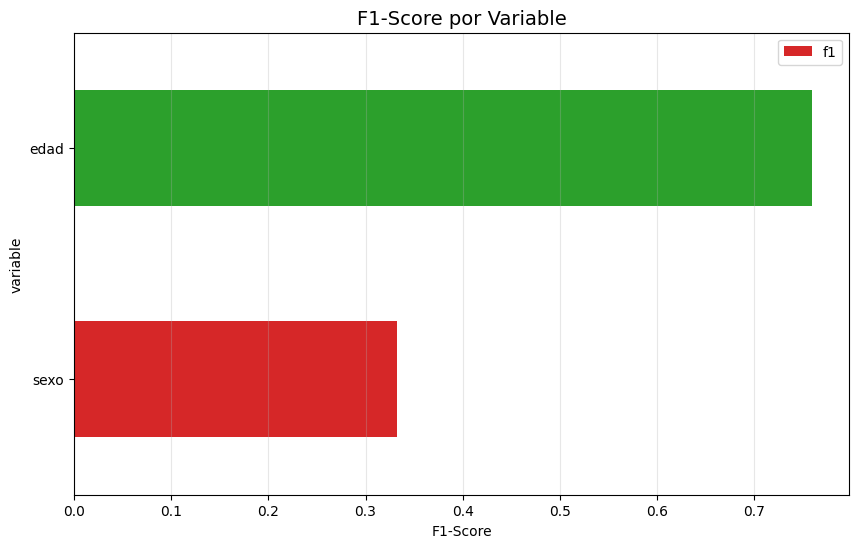

In [8]:
# Gráfico de F1 por variable (ordenado de peor a mejor)
f1_por_variable = df[df['variable'].isin(categorias['demographic'])].groupby('variable')['f1'].mean().sort_values()

plt.figure(figsize=(10, 6))
f1_por_variable.plot(kind='barh', color=['#d62728' if x < 0.7 else '#2ca02c' for x in f1_por_variable])
plt.title('F1-Score por Variable', fontsize=14)
plt.xlabel('F1-Score')
plt.grid(axis='x', alpha=0.3)
plt.legend()
plt.show()

Hay **un considerable desequilibrio en la variable de sexo**. Una escasa proporción de casos correctos se identifica bien, mientras que la proporción de falsos positivos no tiene mucha diferencia con la opuesta (precision).

In [9]:
variable_a_categoria = {}
for categoria, variables in categorias.items():
    for variable in variables:
        variable_a_categoria[variable] = categoria

# 3. Aplica el mapeo al DataFrame
df['categoria'] = df['variable'].map(variable_a_categoria)

/tmp/ipykernel_113868/477832743.py:15: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



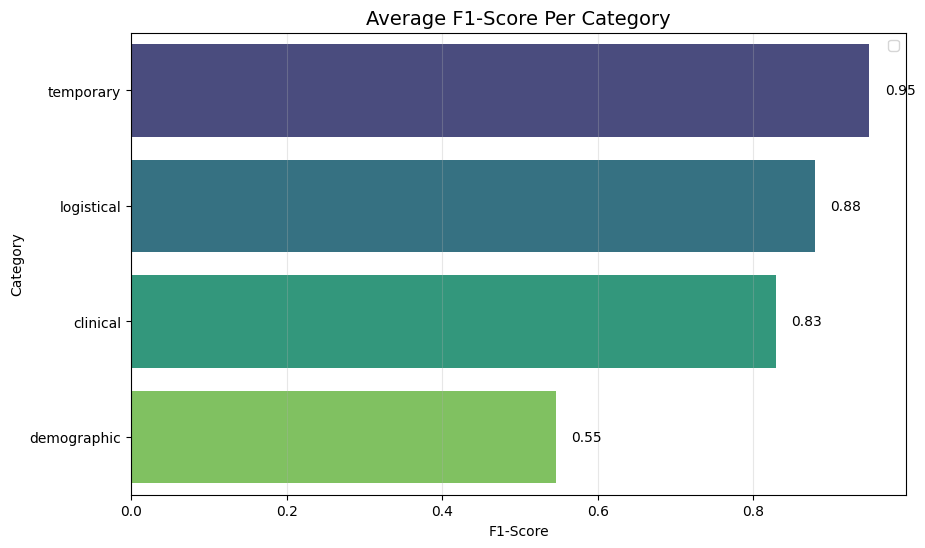


F1-Score Per Category
+-------------+------+
| categoria   |   f1 |
+=============+======+
| temporary   | 0.95 |
+-------------+------+
| logistical  | 0.88 |
+-------------+------+
| clinical    | 0.83 |
+-------------+------+
| demographic | 0.55 |
+-------------+------+


In [10]:
f1_promedio = df.groupby('categoria')['f1'].mean().sort_values(ascending=False)

# Crear gráfico
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=f1_promedio.values, y=f1_promedio.index, palette="viridis", hue=f1_promedio.index, legend=False)
plt.title('Average F1-Score Per Category', fontsize=14)
plt.xlabel('F1-Score')
plt.ylabel('Category')

# Añadir valores numéricos en las barras
for i, v in enumerate(f1_promedio.values):
    ax.text(v + 0.02, i, f"{v:.2f}", color='black', ha='left', va='center')

plt.grid(axis='x', alpha=0.3)
plt.legend()
plt.show()

# Imprimir tabla de F1 por categoría
print("\nF1-Score Per Category")
print(f1_promedio.to_markdown(tablefmt="grid", floatfmt=".2f"))

In [ ]:
import numpy as np
def bootstrap_f1(data, n_iterations=1000):
    f1s = []
    for _ in range(n_iterations):
        sample = data.sample(frac=1, replace=True)
        f1s.append(sample['f1'].mean())
    return np.percentile(f1s, [2.5, 97.5])

ic_clinica = bootstrap_f1(df[df['categoria'] == 'temporal'])
print(f"IC 95% para temporal: {ic_clinica}")

In [ ]:
import numpy as np
def bootstrap_f1(data, n_iterations=1000):
    f1s = []
    for _ in range(n_iterations):
        sample = data.sample(frac=1, replace=True)
        f1s.append(sample['f1'].mean())
    return np.percentile(f1s, [2.5, 97.5])

ic_clinica = bootstrap_f1(df[df['categoria'] == 'demografica'])
print(f"IC 95% para demografica: {ic_clinica}")

In [ ]:
from statsmodels.stats.power import FTestAnovaPower

eta_squared = 0.44
f_squared = eta_squared / (1 - eta_squared)
f = f_squared ** 0.5

analysis = FTestAnovaPower()
power = analysis.power(effect_size=f, nobs=9, alpha=0.05, k_groups=3)
print(power)